# Run the wavelength and the fringe frame maker notebooks first!

In [1]:
import os
os.environ['OPENTSDB_PYTHON_METRICS_TEST_MODE'] = 'True'

In [2]:
import importlib.resources
import requests
from banzai_floyds import settings
from banzai.utils.stage_utils import run_pipeline_stages
from banzai.utils.fits_utils import download_from_s3
import numpy as np
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units

In [3]:
os.environ['DB_ADDRESS'] = 'sqlite:///test_data/test.db'
settings.processed_path= os.path.join(os.getcwd(), 'test_data')
settings.fpack=True
settings.db_address = os.environ['DB_ADDRESS']
settings.RAW_DATA_FRAME_URL = f'https://archive-api.lco.global/frames'

In [4]:
# set up the context object.
import banzai.main
context = banzai.main.parse_args(settings, parse_system_args=False)

In [5]:
from banzai_floyds import dbs
dbs.ingest_standards(settings.db_address)

In [6]:
# Start with just the profile.
settings.ORDERED_STAGES = [
    'banzai.bias.OverscanSubtractor',
    'banzai.trim.Trimmer',
    'banzai.gain.GainNormalizer',
    'banzai.uncertainty.PoissonInitializer',
    'banzai_floyds.orders.OrderLoader',
    # Note that we currently don't apply the order tweak, only calculate it and save it in the header
    'banzai_floyds.orders.OrderTweaker',
    'banzai_floyds.wavelengths.WavelengthSolutionLoader',
    'banzai_floyds.fringe.FringeLoader',
    'banzai_floyds.fringe.FringeCorrector',
    #'banzai_floyds.extract.ProfileFitter',
]
context = banzai.main.parse_args(settings, parse_system_args=False)

In [7]:
test_data = ascii.read(os.path.join(importlib.resources.files('banzai_floyds.tests'), 'data/test_data.dat'))
standards = []
for row in test_data:
    if 'e00.fits' in row['filename']:
        frame_data = requests.get(settings.RAW_DATA_FRAME_URL + f'/{row["frameid"]}/headers/').json()['data']
        coord = SkyCoord(frame_data['RA'], frame_data['DEC'], unit=(units.hourangle, units.deg))
        if dbs.get_standard(coord.ra.deg, coord.dec.deg, settings.db_address, offset_threshold=5) is not None:
            run_pipeline_stages([{'filename': row['filename'], 'RLEVEL': 0, 'frameid': row['frameid']}], context)
            standards.append(row['frameid'])

2023-11-10 12:35:46.260     INFO:      fits_utils: Downloading file coj2m002-en12-20200813-0014-e00.fits.fz from archive. ID: 33851447. | {"filename": "coj2m002-en12-20200813-0014-e00.fits.fz", "attempt_number": 1, "processName": "MainProcess"}
2023-11-10 12:35:48.123     INFO:          stages: Running banzai.stages.OverscanSubtractor | {"filename": "coj2m002-en12-20200813-0014-e00.fits.fz", "site": "coj", "instrument": "floyds02", "epoch": "20200813", "request_num": "2207712", "obstype": "SPECTRUM", "filter": "air", "processName": "MainProcess"}
2023-11-10 12:35:48.126     INFO:          stages: Running banzai.stages.Trimmer | {"filename": "coj2m002-en12-20200813-0014-e00.fits.fz", "site": "coj", "instrument": "floyds02", "epoch": "20200813", "request_num": "2207712", "obstype": "SPECTRUM", "filter": "air", "processName": "MainProcess"}
2023-11-10 12:35:48.126     INFO:            trim: Trimming image | {"filename": "coj2m002-en12-20200813-0014-e00.fits.fz", "site": "coj", "instrument

In [8]:
%debug

> /Users/cmccully/miniconda3/envs/banzai-floyds/lib/python3.10/site-packages/astropy/io/fits/hdu/image.py(291)data()
    289             # Set new values of bitpix, bzero, and bscale now, but wait to
    290             # revise original values until header is updated.
--> 291             self._bitpix = DTYPE2BITPIX[data.dtype.name]
    292             self._bscale = 1
    293             self._bzero = 0



ipdb>  u


> /Users/cmccully/miniconda3/envs/banzai-floyds/lib/python3.10/site-packages/astropy/utils/decorators.py(848)__set__()
    846         obj_dict = obj.__dict__
    847         if self.fset:
--> 848             ret = self.fset(obj, val)
    849             if ret is not None and obj_dict.get(self._key) is ret:
    850                 # By returning the value set the setter signals that it



ipdb>  u


> /Users/cmccully/miniconda3/envs/banzai-floyds/lib/python3.10/site-packages/astropy/io/fits/hdu/image.py(155)__init__()
    153             # and _bscale to the appropriate BITPIX for the data, and always
    154             # sets _bzero=0 and _bscale=1.
--> 155             self.data = data
    156 
    157             # Check again for BITPIX/BSCALE/BZERO in case they changed when the



ipdb>  u


> /Users/cmccully/miniconda3/envs/banzai-floyds/lib/python3.10/site-packages/astropy/io/fits/hdu/image.py(1237)__init__()
   1235         # and is only explicitly defined for the docstring.
   1236 
-> 1237         super().__init__(
   1238             data=data,
   1239             header=header,



ipdb>  u


> /Users/cmccully/miniconda3/envs/banzai-floyds/lib/python3.10/site-packages/astropy/io/fits/hdu/compressed.py(861)_update_header_data()
    859         self._remove_unnecessary_default_extnames(self._header)
    860 
--> 861         image_hdu = ImageHDU(data=self.data, header=self._header)
    862         self._image_header = CompImageHeader(self._header, image_hdu.header)
    863         self._axes = image_hdu._axes



ipdb>  data


*** NameError: name 'data' is not defined


ipdb>  self.data


array([None], dtype=object)


ipdb>  header


*** NameError: name 'header' is not defined


ipdb>  self._header


XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    0 / length of dimension 1                          
NAXIS2  =                    0 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    0 / number of table fields                         
LINWIDE1=    18.35631405646707                                                  
LINTILT1=     8.29424378196516                                                  
POLYORD1=                    3                                                  
POLYDOM1= '[0.0, 1700.0]'                                                       
COEF1_0 =    7420.6338706383

ipdb>  u


> /Users/cmccully/miniconda3/envs/banzai-floyds/lib/python3.10/site-packages/astropy/io/fits/hdu/compressed.py(694)__init__()
    692             # data; Create the initially empty table data array to
    693             # hold the compressed data.
--> 694             self._update_header_data(
    695                 header,
    696                 name,



ipdb>  u


> /Users/cmccully/miniconda3/envs/banzai-floyds/lib/python3.10/site-packages/astropy/utils/decorators.py(604)wrapper()
    602                     warnings.warn(msg, warning_type, stacklevel=2)
    603 
--> 604             return function(*args, **kwargs)
    605 
    606         return wrapper



ipdb>  u


> /Users/cmccully/miniconda3/envs/banzai-floyds/lib/python3.10/site-packages/banzai/utils/fits_utils.py(237)pack()
    235             else:
    236                 quantize_level = 64
--> 237             compressed_hdu = fits.CompImageHDU(data=np.ascontiguousarray(hdu.data), header=hdu.header,
    238                                                quantize_level=quantize_level, quantize_method=1)
    239             hdulist.append(compressed_hdu)



ipdb>  hdu.data
ipdb>  np.ascontiguousarray(hdu.data)


array([None], dtype=object)


ipdb>  q


In [7]:
for row in test_data:
    if 'e00.fits' in row['filename'] and row['frameid'] not in standards:
        run_pipeline_stages([{'filename': row['filename'], 'RLEVEL': 0, 'frameid': row['frameid']}], context)

In [5]:
from banzai_floyds.frames import FLOYDSFrameFactory
factory = FLOYDSFrameFactory()

In [6]:
image = factory.open({'path': './test_data/coj/en12/20200813/processed/coj2m002-en12-20200813-0014-e91-2d.fits.fz'}, context)

In [7]:
from banzai_floyds.extract import get_wavelength_bins
image.wavelength_bins = get_wavelength_bins(image.wavelengths)

In [10]:
from banzai_floyds.extract import bin_data
image.binned_data = bin_data(image.data, image.uncertainty, image.wavelengths,
                             image.orders, image.wavelength_bins)

In [11]:
from banzai_floyds.extract import fit_profile_centers
profile_centers = fit_profile_centers(image.binned_data)

In [12]:
profile_centers

[Legendre([-42.63743148, -10.36254868,  -8.49968533,  22.45148574,
         -9.72839256, -15.13319399], domain=[ 4494.74065168, 10365.41238813], window=[-1.,  1.]),
 Legendre([ 2.95250172,  4.0685062 ,  4.17281957, -6.21629649, -3.60127395,
         7.79946989], domain=[3438.7569325 , 5712.78952944], window=[-1.,  1.])]

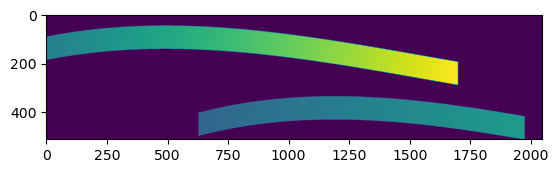

In [15]:
from matplotlib import pyplot
pyplot.imshow(image.wavelengths.data)

In [19]:
profile_centers[0](7500)

-43.74474223610142

In [22]:
import scipy.interpolate
x, y = np.meshgrid(image.data.shape[1], image.data.shape[0])
centers = image.orders.centers(x)
#interpolator = scipy.interpolate.SmoothBivariateSpline(x, y, z)

<bound method Orders.center of <banzai_floyds.orders.Orders object at 0x147566500>>

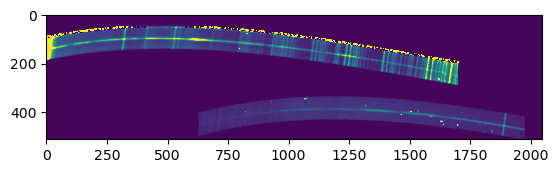

In [25]:
from matplotlib import pyplot
pyplot.imshow(image.data * image.orders.data, vmin=-5, vmax=300)

In [26]:
image.meta

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                  512                                                  
EXTEND  =                    T                                                  
DATADICV= 'LCOGT-FITS-SPECTRO.DIC-0.0.5' / Version number of the data dictionary
HDRVER  = 'LCOGT-HDR-2.0.1'    / Version number of the headers                  
ORIGIN  = 'LCOGT   '           / Organization responsible for the data          
SITEID  = 'coj     '           / ID code of the Observatory site                
SITE    = 'LCOGT node at Siding Spring Observatory' / Site of the Observatory   
ENCID   = 'clma    '           / ID code of the Enclosure                       
ENCLOSUR= 'Clamshell-02'    